In [11]:
import pandas as pd
import numpy as np
import openpyxl as xl
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import auto_arima

In [12]:
df=pd.read_excel("FS_DATA_DAS.xlsx")
df

,Date,Recettes,Change,IPC
0,1998-10-01,4.511900e+08,16.3043,7.497835
1,1998-11-01,3.793800e+08,16.5948,8.022774
2,1998-12-01,3.967000e+08,16.5046,7.447713
3,1999-01-01,4.376500e+08,16.7778,7.375875
4,1999-02-01,4.147200e+08,16.8943,7.932369
...,...,...,...,...
307,2024-05-01,4.974492e+09,132.5137,28.300000
308,2024-06-01,6.102811e+09,132.2823,28.900000
309,2024-07-01,4.995281e+09,131.7522,30.000000
310,2024-08-01,4.843745e+09,131.5083,29.300000


In [13]:



# ⚠️ S'assurer que l'index est une date
df.index = pd.to_datetime(df.index)

# ⚠️ Supprimer les valeurs manquantes
df = df[['Recettes', 'IPC', 'Change']].dropna()

# 🧪 Séparer données d'entraînement et test (par exemple, les 12 derniers mois)
train = df[:-12]
test = df[-12:]

# 🔢 Définir les séries
y_train = train['Recettes']
exog_train = train[['IPC', 'Change']]

y_test = test['Recettes']
exog_test = test[['IPC', 'Change']]

# 🔧 Estimer le modèle SARIMAX (exemple : ARIMA(1,1,1) avec saisonnalité annuelle)
model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),  # saisonnalité annuelle mensuelle
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)

# 📈 Résumé
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                           Recettes   No. Observations:                  300
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5852.559
Date:                            Wed, 25 Jun 2025   AIC                          11719.119
Time:                                    19:11:18   BIC                          11744.385
Sample:                                01-01-1970   HQIC                         11729.261
                                     - 01-01-1970                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IPC        -1.221e+07   7.35e-10  -1.66e+16      0.000   -1.22e+07   -1.22e+07
Change     -7.981e+06   3.97e-10  -

In [14]:
df = df[['Recettes', 'IPC', 'Change']].dropna()
df.index = pd.to_datetime(df.index)

# Séparer en train/test
train = df[:-12]
test = df[-12:]

y_train = train['Recettes']
exog_train = train[['IPC', 'Change']]
exog_test = test[['IPC', 'Change']]


In [15]:
stepwise_model = auto_arima(
    y=y_train,
    exogenous=exog_train,
    seasonal=True,
    m=12,  # fréquence saisonnière (12 pour données mensuelles)
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=12829.626, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12975.345, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12875.195, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12849.922, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12973.475, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=12847.322, Time=0.46 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=12836.660, Time=0.52 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=12829.431, Time=1.60 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=12829.257, Time=1.38 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=12829.480, Time=1.08 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=12833.808, Time=0.61 sec
 ARIMA(3,1,2)(2,0,0)[12] intercept   : AIC=12830.759, Time=1.33 sec
 ARIMA(2,1,3)(2,0,0)[12] intercept   : AIC=12826.046, Time=1.98 sec
 ARIMA(2,1,3)(1,0,0)[12] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(2,1,

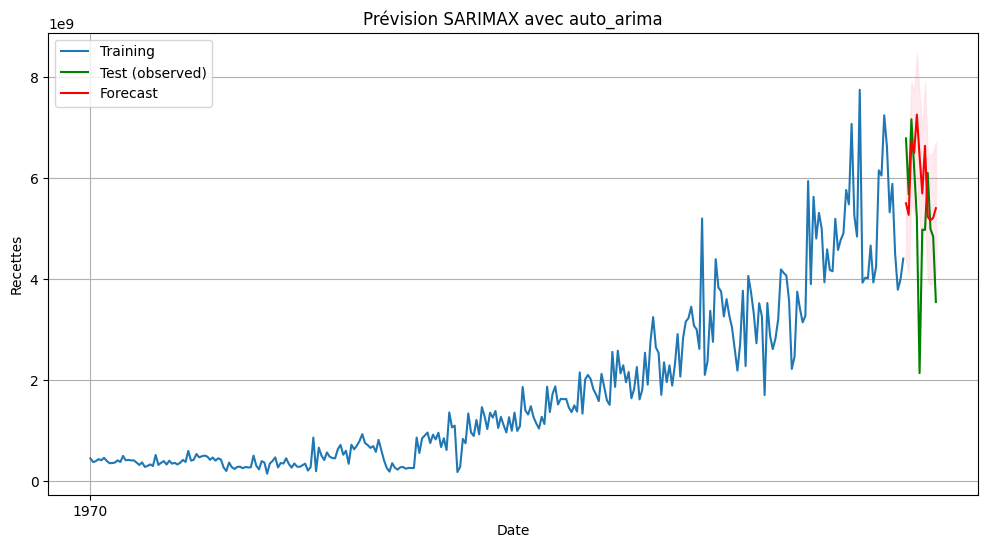

In [16]:
pred = results.get_forecast(steps=12, exog=exog_test)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

plt.figure(figsize=(12,6))
plt.plot(y_train, label='Training')
plt.plot(test['Recettes'], label='Test (observed)', color='green')
plt.plot(pred_mean, label='Forecast', color='red')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Prévision SARIMAX avec auto_arima')
plt.xlabel('Date')
plt.ylabel('Recettes')
plt.legend()
plt.grid(True)
plt.show()



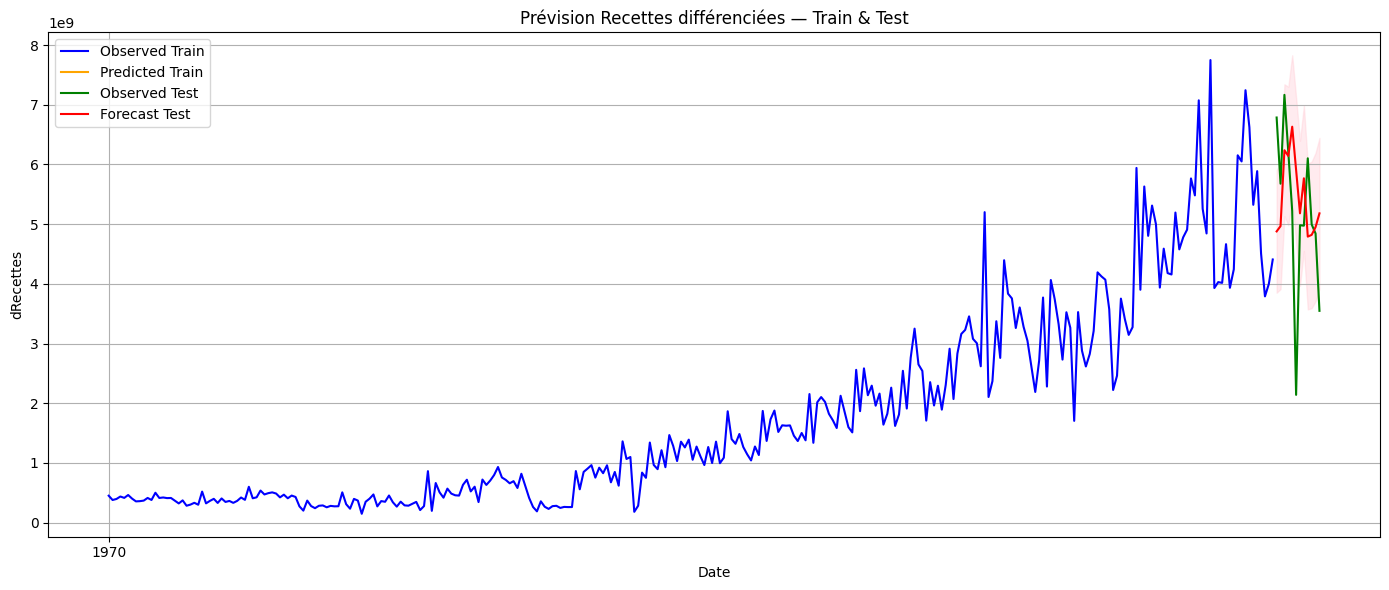

In [22]:
# 🔹 Prédictions sur l'ensemble d'entraînement
train_pred = stepwise_model.predict(n_periods=len(y_train), exogenous=exog_train)

# 🔹 Prédictions sur l'ensemble de test
forecast_test, confint = stepwise_model.predict(n_periods=12, exogenous=exog_test, return_conf_int=True)

# 🔹 Construction des index pour prédictions
train_index = y_train.index
test_index = y_test.index

# 🔹 Séries pandas
train_pred_series = pd.Series(train_pred, index=train_index)
forecast_series = pd.Series(forecast_test, index=test_index)
lower_series = pd.Series(confint[:, 0], index=test_index)
upper_series = pd.Series(confint[:, 1], index=test_index)

# 🔹 Tracer
plt.figure(figsize=(14,6))

plt.plot(y_train, label='Observed Train', color='blue')
plt.plot(train_pred_series, label='Predicted Train', color='orange')
plt.plot(y_test, label='Observed Test', color='green')
plt.plot(forecast_series, label='Forecast Test', color='red')
plt.fill_between(test_index, lower_series, upper_series, color='pink', alpha=0.3)
plt.title('Prévision Recettes différenciées — Train & Test')
plt.xlabel('Date')
plt.ylabel('dRecettes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
